California Housing Regression Analysis

Objectif: Prédire le prix médian des maisons (variable continue)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("CALIFORNIA HOUSING REGRESSION ANALYSIS")
print("="*60)

CALIFORNIA HOUSING REGRESSION ANALYSIS


In [3]:
# 1. CHARGEMENT DES DONNÉES
print("\n1. CHARGEMENT DES DONNÉES")
print("-" * 30)

# Chargement du dataset California Housing
california_housing = fetch_california_housing()
df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df['target'] = california_housing.target

print(f"Shape du dataset: {df.shape}")
print(f"Features: {list(df.columns[:-1])}")
print(f"Target: Prix médian des maisons (en centaines de milliers de dollars)")


1. CHARGEMENT DES DONNÉES
------------------------------
Shape du dataset: (20640, 9)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Prix médian des maisons (en centaines de milliers de dollars)


In [4]:
# 2. NETTOYAGE ET PRÉTRAITEMENT
print("\n2. NETTOYAGE ET PRÉTRAITEMENT")
print("-" * 35)

# Vérification des valeurs manquantes
print("Valeurs manquantes par colonne:")
missing_values = df.isnull().sum()
print(missing_values)

# Vérification des types de données
print("\nTypes de données:")
print(df.dtypes)

# Statistiques de base
print("\nStatistiques descriptives:")
print(df.describe())



2. NETTOYAGE ET PRÉTRAITEMENT
-----------------------------------
Valeurs manquantes par colonne:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

Types de données:
MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
target        float64
dtype: object

Statistiques descriptives:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        


3. ANALYSE EXPLORATOIRE DES DONNÉES
----------------------------------------


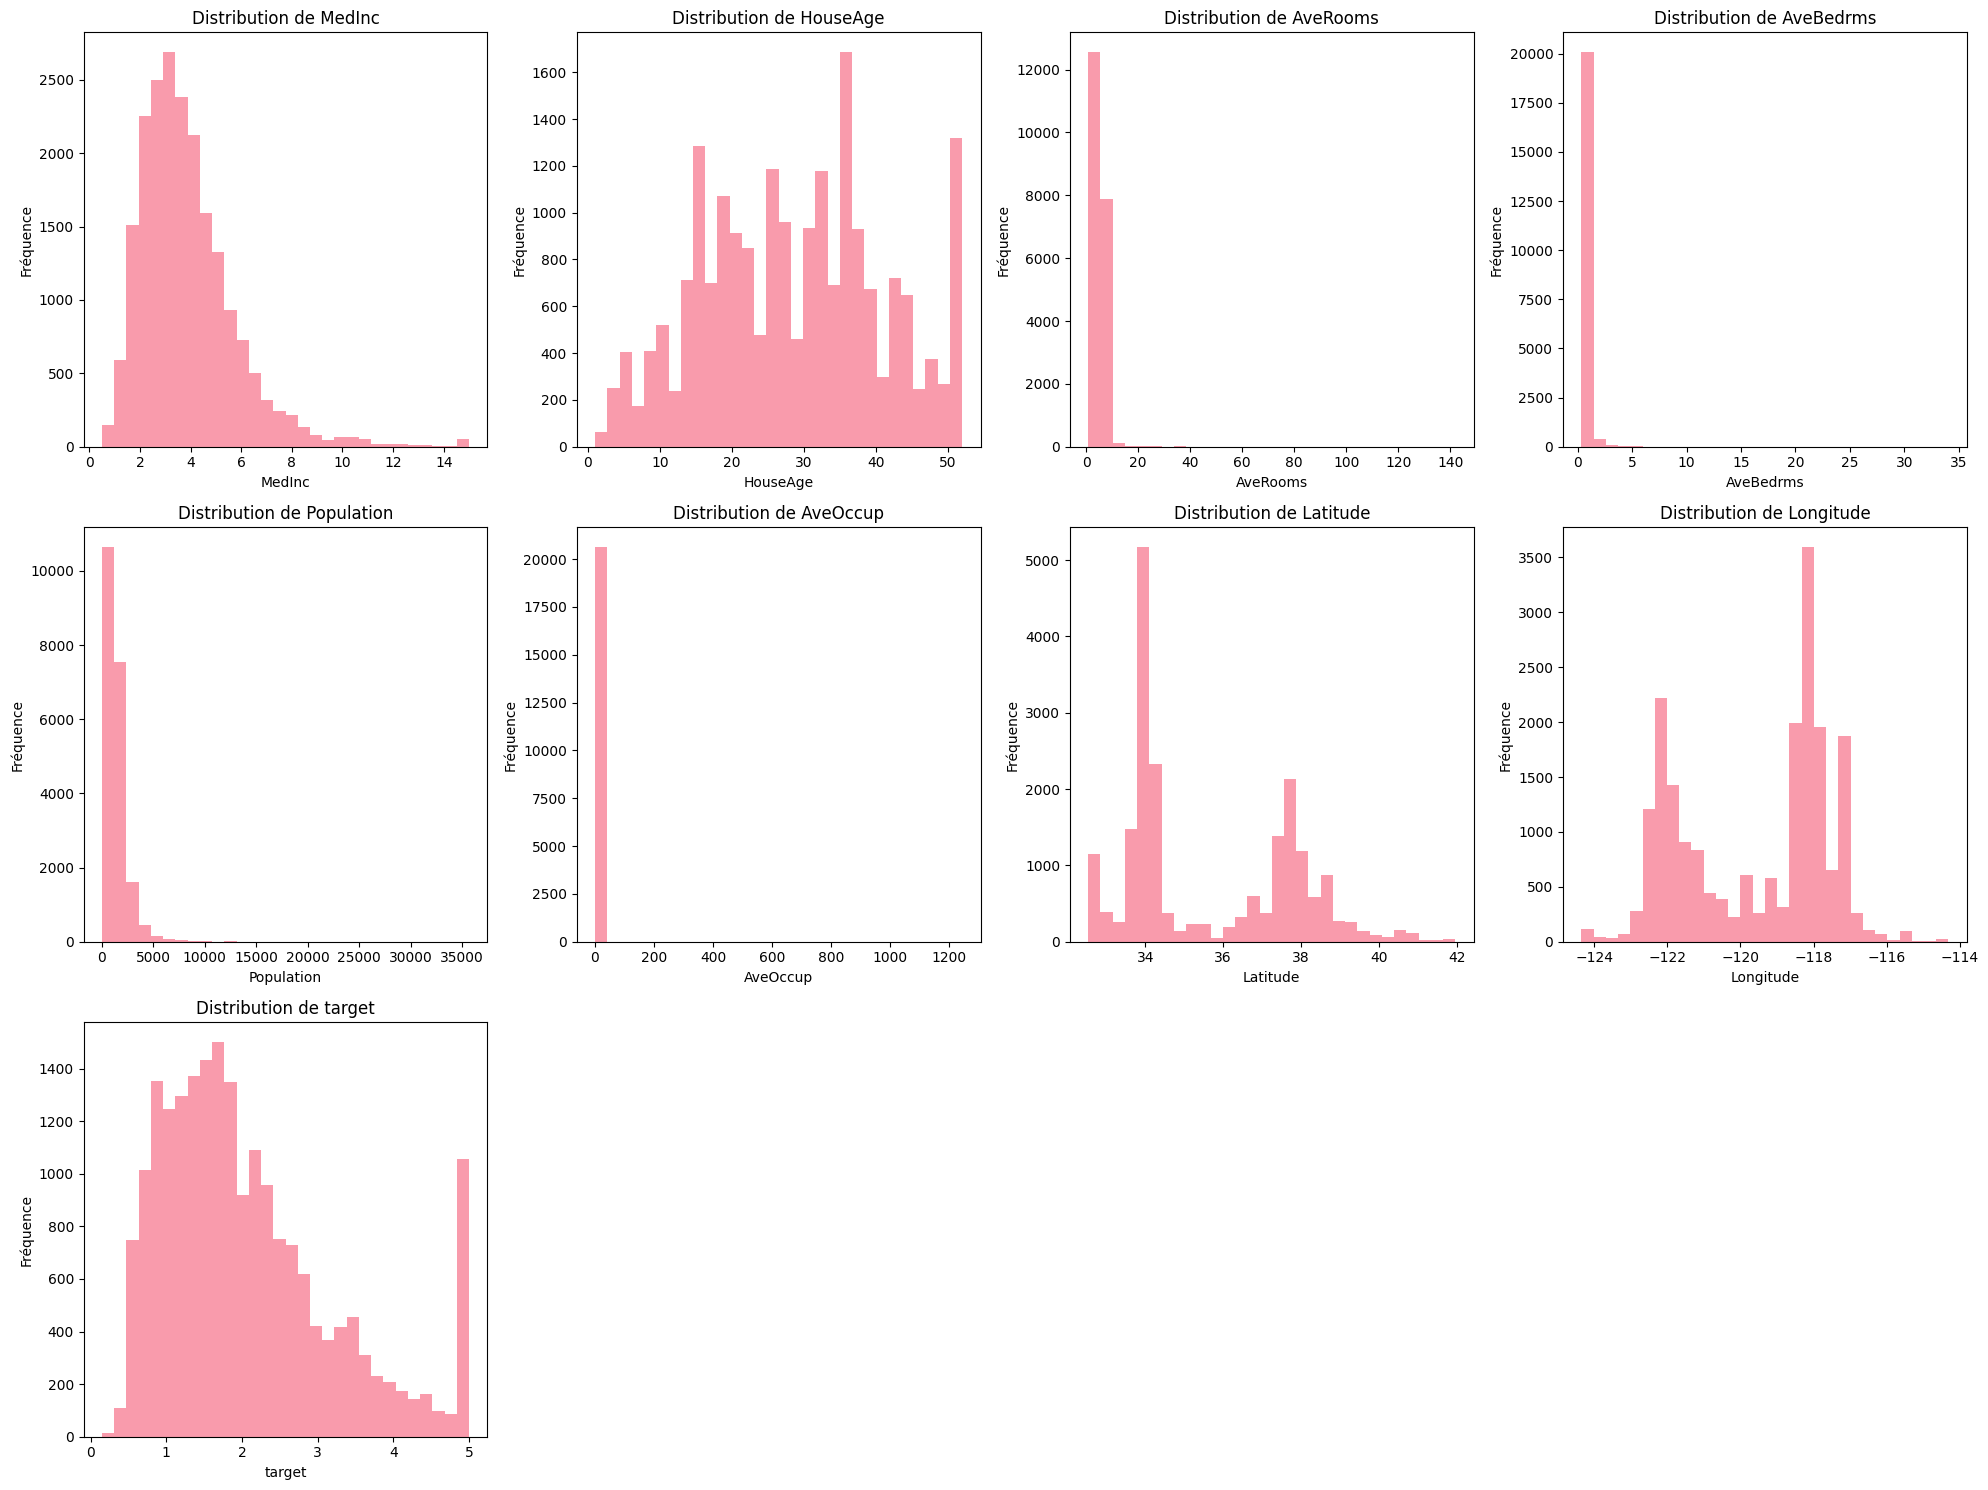

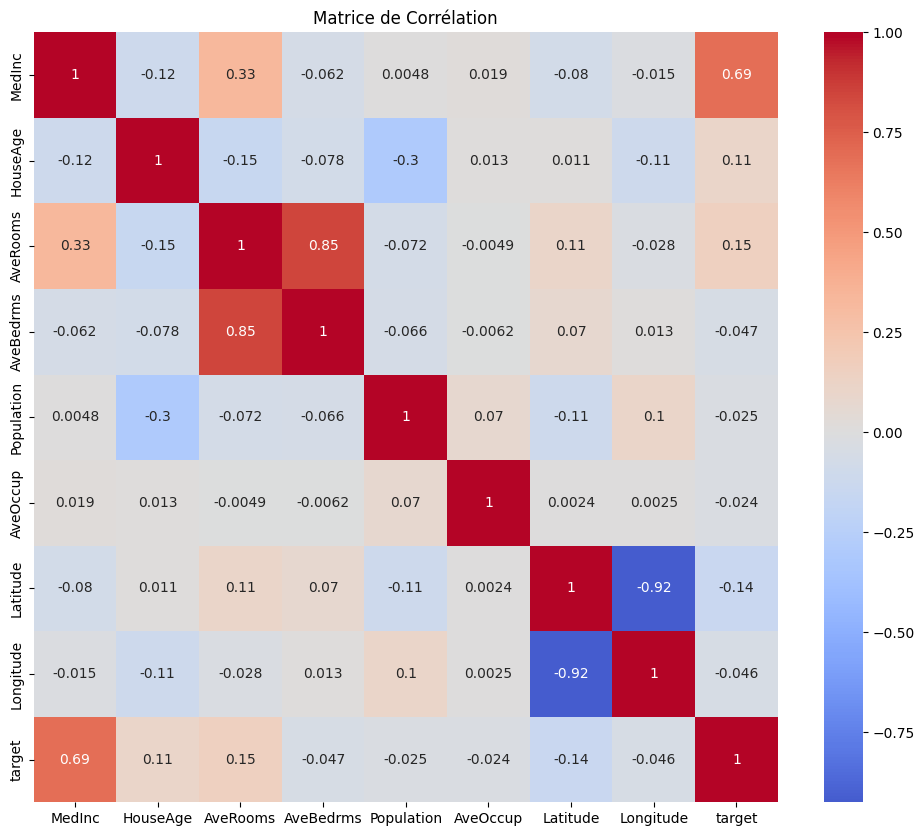


Variables les plus corrélées avec le target:
MedInc      0.688075
AveRooms    0.151948
Latitude    0.144160
HouseAge    0.105623
Name: target, dtype: float64


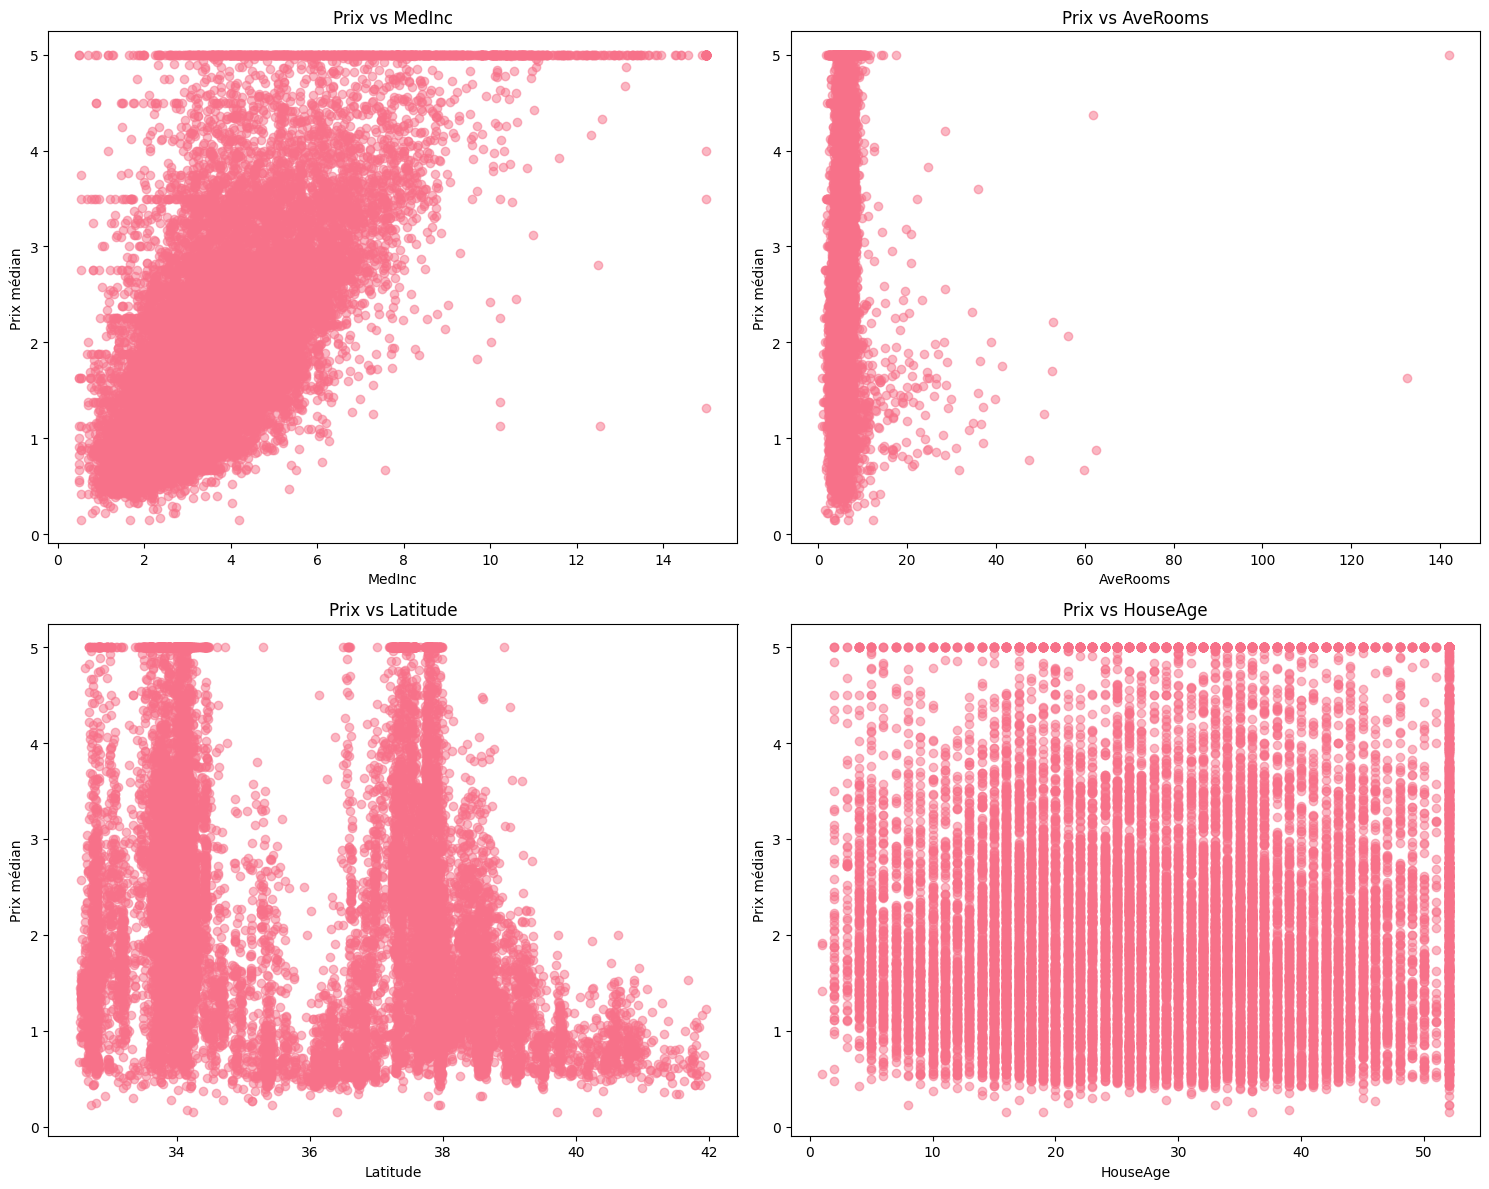

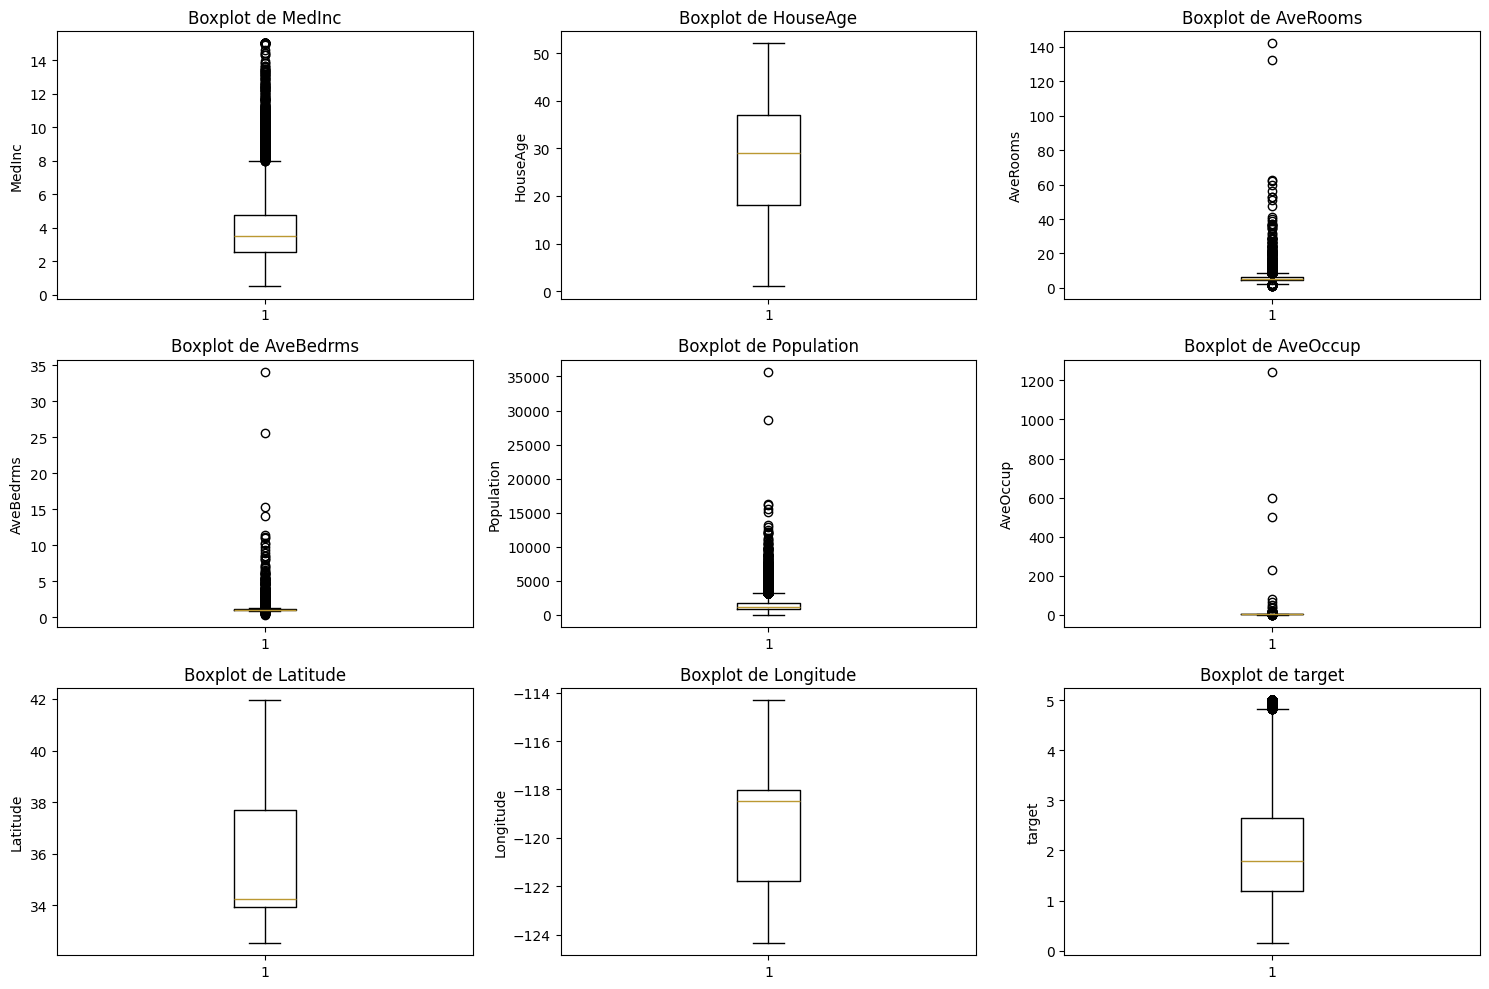

In [5]:
# 3. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
print("\n3. ANALYSE EXPLORATOIRE DES DONNÉES")
print("-" * 40)

# Configuration pour les graphiques
fig = plt.figure(figsize=(20, 15))

# Histogrammes de toutes les variables
plt.subplot(3, 4, 1)
for i, col in enumerate(df.columns):
    plt.subplot(3, 4, i+1)
    plt.hist(df[col], bins=30, alpha=0.7)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

# Matrice de corrélation
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation')
plt.show()

# Scatter plots des variables les plus corrélées avec le target
most_correlated = correlation_matrix['target'].abs().sort_values(ascending=False)[1:5]
print(f"\nVariables les plus corrélées avec le target:")
print(most_correlated)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, var in enumerate(most_correlated.index):
    axes[i].scatter(df[var], df['target'], alpha=0.5)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Prix médian')
    axes[i].set_title(f'Prix vs {var}')

plt.tight_layout()
plt.show()

# Boxplots pour détecter les outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns):
    plt.subplot(3, 3, i+1)
    plt.boxplot(df[col])
    plt.title(f'Boxplot de {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [6]:
# 4. SPLIT TRAIN/VALIDATION/TEST (60%/20%/20%)
print("\n4. DIVISION DES DONNÉES")
print("-" * 25)

X = df.drop('target', axis=1)
y = df['target']

# Premier split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Deuxième split: 20% validation, 20% test (sur les 40% restants)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Taille train set: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Taille validation set: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Taille test set: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")


4. DIVISION DES DONNÉES
-------------------------
Taille train set: 12384 (60.0%)
Taille validation set: 4128 (20.0%)
Taille test set: 4128 (20.0%)


In [7]:
# 5. FEATURE ENGINEERING / SÉLECTION
print("\n5. FEATURE ENGINEERING")
print("-" * 25)

# Normalisation avec StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Normalisation effectuée avec StandardScaler")
print(f"Moyenne des features après normalisation (train): {X_train_scaled.mean(axis=0).round(3)}")
print(f"Écart-type des features après normalisation (train): {X_train_scaled.std(axis=0).round(3)}")


5. FEATURE ENGINEERING
-------------------------
Normalisation effectuée avec StandardScaler
Moyenne des features après normalisation (train): [-0.  0. -0. -0.  0.  0. -0. -0.]
Écart-type des features après normalisation (train): [1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
# 6. BASELINE ET MODÉLISATION INITIALE
print("\n6. MODÉLISATION BASELINE - RÉGRESSION LINÉAIRE")
print("-" * 50)

# Régression linéaire simple
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Prédictions sur le set de validation
y_val_pred_lr = lr.predict(X_val_scaled)

# Métriques
mse_lr = mean_squared_error(y_val, y_val_pred_lr)
mae_lr = mean_absolute_error(y_val, y_val_pred_lr)
r2_lr = r2_score(y_val, y_val_pred_lr)

print(f"Régression Linéaire - Validation Set:")
print(f"MSE: {mse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")
print(f"R²: {r2_lr:.4f}")

# Importance des variables
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_,
    'abs_coefficient': np.abs(lr.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nImportance des variables (coefficients):")
print(feature_importance)


6. MODÉLISATION BASELINE - RÉGRESSION LINÉAIRE
--------------------------------------------------
Régression Linéaire - Validation Set:
MSE: 0.5326
MAE: 0.5336
R²: 0.5920

Importance des variables (coefficients):
      feature  coefficient  abs_coefficient
6    Latitude    -0.894468         0.894468
7   Longitude    -0.870951         0.870951
0      MedInc     0.850920         0.850920
3   AveBedrms     0.361782         0.361782
2    AveRooms    -0.314198         0.314198
1    HouseAge     0.119466         0.119466
5    AveOccup    -0.042436         0.042436
4  Population    -0.001456         0.001456


In [9]:
# 7. RÉGULARISATION
print("\n7. RÉGULARISATION")
print("-" * 20)

# Ridge Regression (L2)
print("Ridge Regression (L2 Regularization):")
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)

best_ridge = ridge_grid.best_estimator_
y_val_pred_ridge = best_ridge.predict(X_val_scaled)

mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)
r2_ridge = r2_score(y_val, y_val_pred_ridge)

print(f"Meilleur alpha Ridge: {ridge_grid.best_params_['alpha']}")
print(f"MSE: {mse_ridge:.4f}")
print(f"MAE: {mae_ridge:.4f}")
print(f"R²: {r2_ridge:.4f}")

# Lasso Regression (L1)
print("\nLasso Regression (L1 Regularization):")
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_scaled, y_train)

best_lasso = lasso_grid.best_estimator_
y_val_pred_lasso = best_lasso.predict(X_val_scaled)

mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
mae_lasso = mean_absolute_error(y_val, y_val_pred_lasso)
r2_lasso = r2_score(y_val, y_val_pred_lasso)

print(f"Meilleur alpha Lasso: {lasso_grid.best_params_['alpha']}")
print(f"MSE: {mse_lasso:.4f}")
print(f"MAE: {mae_lasso:.4f}")
print(f"R²: {r2_lasso:.4f}")

# Comparaison des modèles
print("\nCOMPARAISON DES MODÈLES (Validation Set):")
print("-" * 45)
results_val = pd.DataFrame({
    'Modèle': ['Linear Regression', 'Ridge', 'Lasso'],
    'MSE': [mse_lr, mse_ridge, mse_lasso],
    'MAE': [mae_lr, mae_ridge, mae_lasso],
    'R²': [r2_lr, r2_ridge, r2_lasso]
})
print(results_val)

# Sélection du meilleur modèle
best_model_idx = results_val['R²'].idxmax()
best_model_name = results_val.loc[best_model_idx, 'Modèle']
print(f"\nMeilleur modèle selon R²: {best_model_name}")


7. RÉGULARISATION
--------------------
Ridge Regression (L2 Regularization):
Meilleur alpha Ridge: 10.0
MSE: 0.5325
MAE: 0.5336
R²: 0.5921

Lasso Regression (L1 Regularization):
Meilleur alpha Lasso: 0.001
MSE: 0.5324
MAE: 0.5336
R²: 0.5922

COMPARAISON DES MODÈLES (Validation Set):
---------------------------------------------
              Modèle       MSE       MAE        R²
0  Linear Regression  0.532564  0.533616  0.592010
1              Ridge  0.532471  0.533555  0.592081
2              Lasso  0.532353  0.533638  0.592172

Meilleur modèle selon R²: Lasso



8. ÉVALUATION FINALE SUR LE TEST SET
----------------------------------------
Modèle final: Lasso
Métriques sur le Test Set:
MSE: 0.5531
MAE: 0.5337
R²: 0.5966

Intervalle de confiance à 95% pour R²: [0.5487, 0.6302]


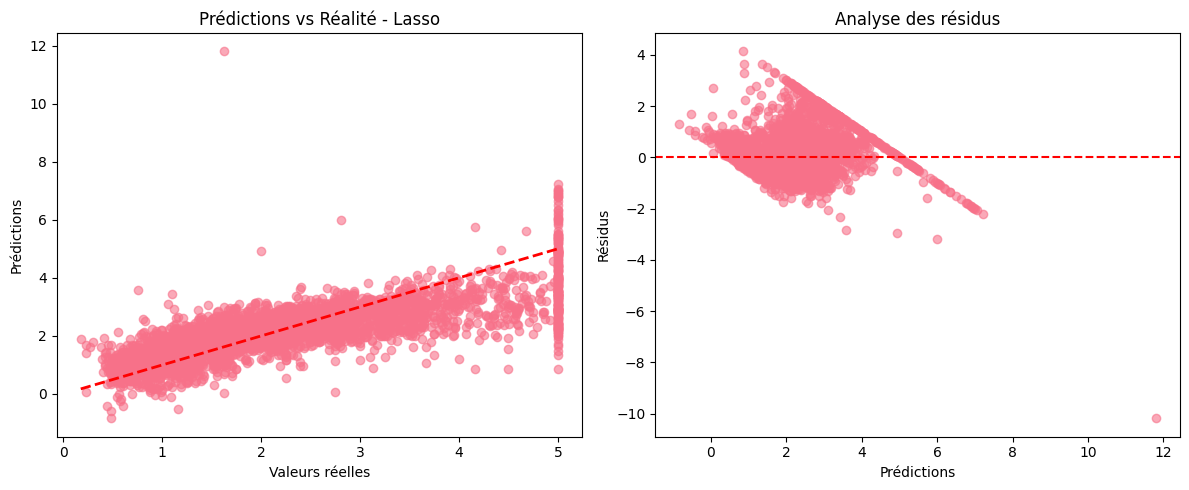

In [10]:
# 8. ÉVALUATION FINALE SUR LE TEST SET
print("\n8. ÉVALUATION FINALE SUR LE TEST SET")
print("-" * 40)

# Utilisation du meilleur modèle identifié
if best_model_name == 'Linear Regression':
    final_model = lr
elif best_model_name == 'Ridge':
    final_model = best_ridge
else:
    final_model = best_lasso

# Prédictions sur le test set
y_test_pred = final_model.predict(X_test_scaled)

# Métriques finales
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Modèle final: {best_model_name}")
print(f"Métriques sur le Test Set:")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"R²: {r2_test:.4f}")

# Calcul des intervalles de confiance (approximation bootstrap)
n_bootstrap = 1000
bootstrap_r2 = []

np.random.seed(42)
for i in range(n_bootstrap):
    # Échantillonnage bootstrap
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    y_test_boot = y_test.iloc[indices]
    y_pred_boot = y_test_pred[indices]

    # Calcul du R² pour cet échantillon
    r2_boot = r2_score(y_test_boot, y_pred_boot)
    bootstrap_r2.append(r2_boot)

# Intervalles de confiance à 95%
ci_lower = np.percentile(bootstrap_r2, 2.5)
ci_upper = np.percentile(bootstrap_r2, 97.5)

print(f"\nIntervalle de confiance à 95% pour R²: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Graphique des prédictions vs valeurs réelles
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title(f'Prédictions vs Réalité - {best_model_name}')

plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Analyse des résidus')

plt.tight_layout()
plt.show()

In [11]:
# 9. CONCLUSIONS
print("\n9. CONCLUSIONS")
print("-" * 15)

print("Interprétation de l'importance des variables:")
if best_model_name == 'Linear Regression':
    importance_df = feature_importance
elif best_model_name == 'Ridge':
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_ridge.coef_,
        'abs_coefficient': np.abs(best_ridge.coef_)
    }).sort_values('abs_coefficient', ascending=False)
else:  # Lasso
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_lasso.coef_,
        'abs_coefficient': np.abs(best_lasso.coef_)
    }).sort_values('abs_coefficient', ascending=False)

print(importance_df)

print(f"\nRésultats principaux:")
print(f"- Modèle sélectionné: {best_model_name}")
print(f"- Performance (R² test): {r2_test:.4f}")
print(f"- Erreur moyenne absolue: {mae_test:.4f} (centaines de milliers $)")
print(f"- Variable la plus importante: {importance_df.iloc[0]['feature']}")


9. CONCLUSIONS
---------------
Interprétation de l'importance des variables:
      feature  coefficient  abs_coefficient
6    Latitude    -0.883441         0.883441
7   Longitude    -0.859223         0.859223
0      MedInc     0.845594         0.845594
3   AveBedrms     0.347819         0.347819
2    AveRooms    -0.300319         0.300319
1    HouseAge     0.120291         0.120291
5    AveOccup    -0.041469         0.041469
4  Population    -0.000186         0.000186

Résultats principaux:
- Modèle sélectionné: Lasso
- Performance (R² test): 0.5966
- Erreur moyenne absolue: 0.5337 (centaines de milliers $)
- Variable la plus importante: Latitude


Pistes d'amélioration:

- Feature engineering avancé (interactions, polynômes)
- Modèles non-linéaires (Random Forest, XGBoost)
- Traitement plus poussé des outliers
- Validation croisée plus robuste
- Ensemble methods